<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_6_3_Semantic_Segmentation_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

The following is adopted and adapted from the following two sources for the Computer Vision course at the University of South Florida, Tampa.

1. Introduction to Semantic Segmentation (Satya Mallick)
https://www.learnopencv.com/tag/semantic-segmentation/)
2. Dive into Deep Learning https://d2l.ai/chapter_computer-vision/transposed-conv.html)

---------

* Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.

* There are a few more types of Segmentation, you can read about it more here: https://www.learnopencv.com/image-segmentation/

So, let's say we have the following image.

![](https://learnopencv.com/wp-content/uploads/2018/10/image-segmentation.gif)
<small> Source: Pexels </small>

And then given the above image its semantically segmentated image would be the following

![](https://learnopencv.com/wp-content/uploads/2018/10/semantic-segmentation.jpg)

As you can see, that each pixel in the image is classified to its respective class.

This is in most simple terms what Semantic Segmentation is.

## Applications of Segmentation


The most common use case for the Semantic Segmentation is in:

1. **Autonomous Driving**

  <img src="https://cdn-images-1.medium.com/max/1600/1*JKmS08bllQ8SCajIPyiBBQ.png" width="400"/> <br/>
  <small> Source: CityScapes Dataset </small>
  
  In autonomous driving, the image from the camera is semantically segmented, with each pixel classified into a class. This pixel-level segmentation helps the computer precisely locate what is present in its surroundings and thus helps the car act accordingly.


2. **Facial Segmentation**

  <img src="https://i.ytimg.com/vi/vrvwfFej_r4/maxresdefault.jpg" width="400"/> <br/>
  <small> Source: https://github.com/massimomauro/FASSEG-repository/blob/master/papers/multiclass_face_segmentation_ICIP2015.pdf </small>

  Facial Segmentation segments each part of the face into a category, like lips, eyes, etc. This technique is used for many purposes, such as age estimation, facial expression analysis, and emotional analysis.
  

3. **Indoor Object Segmentation**

  
  <small> Source: http://buildingparser.stanford.edu/dataset.html </small>

Guess where this is used -- in AR (Augmented Reality) and VR (Virtual Reality). When required, AR applications segment the indoor area to understand where there are chairs, tables, people, walls, and other obstacles.


4. **Geo-Land Sensing**

  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0924271616305305-fx1_lrg.jpg" width="400"/> <br/>
  <small> Source: https://www.sciencedirect.com/science/article/pii/S0924271616305305 </small>

Geo-Sensing is a way of categorizing each pixel in satellite images into a category such that we can track the land cover of each area. So, say in some areas there is heavy deforestation, then appropriate measures can be taken.


# Transposed Convolution (need this concept)

* The layers in convolutional neural networks often reduce the input width and height or keep them unchanged.

* Sometimes, we need to increase the width and height or upsample, such as we will need to do in semantic segmentation.

* This upsampling is the operation we will study next.

* Recall the topics of interpolations and subsampling that we had studied earlier. What we will study here is a different way of doing the interpolation operation.



In [1]:
!pip install d2l==0.16.2
import torch
from torch import nn
from d2l import torch as d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:00


## Reading the [Pascal VOC Dataset](http://host.robots.ox.ac.uk/pascal/VOC/)

We will use randomly cropped image of size $320\times 480$ as inputs, so both the height and width are divisible by 32.


In [2]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)
voc_dir = '../data/VOCdevkit/VOC2012'

read 1114 examples


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


read 1078 examples


Text(0.5, 1.0, 'Object segmentation label')

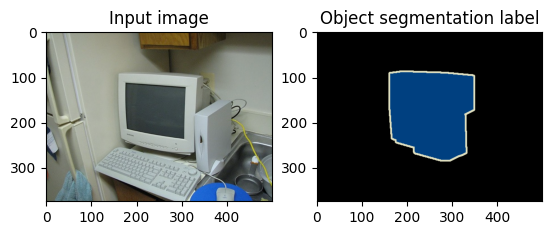

In [3]:
import matplotlib.pyplot as plt

data = train_iter.dataset.features[0].numpy()
label = train_iter.dataset.labels[0].numpy()
data /= (data.max())

plt.subplot(1,2,1)
plt.imshow (data.transpose([1,2,0])) #(M, N, 3): an image with RGB values (0-1 float or 0-255 int).
plt.title('Input image')
plt.subplot(1,2,2)
plt.imshow (label.transpose([1,2,0]))
plt.title('Object segmentation label')

In [4]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'


Mounted at /content/drive


## Basic 2D Transposed Convolution

Let us consider a basic case: both input and output channels are 1, with 0 padding and 1 stride. The figure below illustrates how transposed convolution with a $2\times 2$ kernel is computed on the $2\times 2$ input matrix.



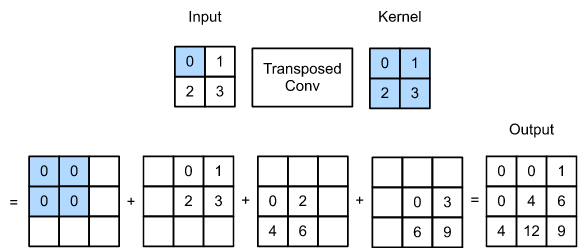

## Code: `trans_conv`

In [6]:
def trans_conv(X, K): #X is input and K is kernel
    h, w = K.shape  # get shape of kernel
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1)) #expanded shape of output
    for i in range(X.shape[0]):  # loops over the input X
        for j in range(X.shape[1]):
            '''block add and assign. This is different from convolution'''
            Y[i:i + h, j:j + w] += X[i, j] * K
    return Y

**This is different from convolution.**

Remember that convolution computes results by `Y[i, j] = (X[i: i + h, j: j + w] * K).sum()`, which summarizes input values through the kernel. In contrast, the transposed convolution **spreads** input values through the kernel, which results in a larger output shape.

In [7]:
'''Example of transposed convolution operation'''
X = torch.tensor([[0., 1], [2, 3]])
K = torch.tensor([[0., 1], [2, 3]])
Z = trans_conv(X, K)
print('X=\n{}\nK=\n{}\nZ=\n{}'.format(X, K, Z))

X=
tensor([[0., 1.],
        [2., 3.]])
K=
tensor([[0., 1.],
        [2., 3.]])
Z=
tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])


## Code: `nn.ConvTranspose2d`

Alternatively, we can use `nn.ConvTranspose2d` to obtain the same results. As we have for `nn.Conv2d`, both input and kernel should be 4-D tensors (batch_size, channels, height, width).


In [8]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=(2,2), bias=False)
tconv.weight.data = K
out = tconv(X)

print('X shape: ', X.shape, 'K shape: ', K.shape, '\nOutput shape:', out.shape, '\n', out)

X shape:  torch.Size([1, 1, 2, 2]) K shape:  torch.Size([1, 1, 2, 2]) 
Output shape: torch.Size([1, 1, 3, 3]) 
 tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)


## Padding, Strides, and Channels

While we apply padding elements to the input in convolution, here they are applied to the output of the *transposed* convolution. A $1\times 1$ padding means we first compute the output as usual, then **remove** the first/last rows and columns.


In [9]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
out = tconv(X)
print('X shape: ', X.shape, 'K shape: ', K.shape, '\nOutput shape:', out.shape, '\n', out)

X shape:  torch.Size([1, 1, 2, 2]) K shape:  torch.Size([1, 1, 2, 2]) 
Output shape: torch.Size([1, 1, 1, 1]) 
 tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)


Similarly, strides are applied to outputs as well.


In [10]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

* The **multi-channel** extension of the transposed convolution is the same as the convolution. When the input has multiple channels, denoted by $c_i$, the transposed convolution assigns a $k_h\times k_w$ kernel matrix to each input channel. If the output has a channel size $c_o$, then we have a $c_i\times k_h\times k_w$ kernel for each output channel, whose outputs are summed.


* If we feed $X$ into a convolutional layer $f$ to compute $Y=f(X)$ and create a transposed convolution layer $g$ with the same hyperparameters as $f$ except for the output channel set to be the channel size of $X$, then $g(Y)$ should have the same shape as $X$. Let us verify this statement.


In [11]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

True

## Why is it called transposed convolution?

* Convolutions can be implemented as a **single** matrix multiply. This is how they are implemented on GPUs.

    https://stackoverflow.com/questions/16798888/2-d-convolution-as-a-matrix-matrix-multiplication

* If we do the multiplication with the **transpose** of the weight matrix, we end up with an expanded, interpolated version.

* We illustrate below using a $3\times 3$ input $X$ with a $2\times 2$ kernel $K$.


In [12]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[0, 1],
                  [2, 3]])
Y = d2l.corr2d(X, K)
# remember convolution is correlation with the "flipped" kernel, so this is not quite convolution, but okay as illustration
print('\nX=', X, '\nK=\n', K, '\nY=\n', Y)


X= tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]]) 
K=
 tensor([[0, 1],
        [2, 3]]) 
Y=
 tensor([[19., 25.],
        [37., 43.]])


Next, we rewrite convolution kernel $K$ as a matrix $W$ (Toeplitz matrix form). Its shape will be $(4, 9)$, where the $i^\mathrm{th}$ row present applying the kernel to the input to generate the $i^\mathrm{th}$ output element.


In [13]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    print('k=\n', k)
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
print('W=\n', W)

k=
 tensor([0., 1., 0., 2., 3.])
W=
 tensor([[0., 1., 0., 2., 3., 0., 0., 0., 0.],
        [0., 0., 1., 0., 2., 3., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 2., 3., 0.],
        [0., 0., 0., 0., 0., 1., 0., 2., 3.]])


Then the convolution operator can be implemented by matrix multiplication with proper reshaping.


In [14]:
print('X=\n', X)
#Performs a matrix-vector product of the matrix input and the vector vec.

print('Convolution output by matrix multiply:\n', torch.mv(W, X.reshape(-1)).reshape(2, 2))

print('Convolution output by traditional convolution (earlier):\n', Y)


X=
 tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
Convolution output by matrix multiply:
 tensor([[19., 25.],
        [37., 43.]])
Convolution output by traditional convolution (earlier):
 tensor([[19., 25.],
        [37., 43.]])


We can implement transposed convolution as a matrix multiplication as well by reusing `kernel2matrix`. To reuse the generated $W$, we construct a $2\times 2$ input, so the corresponding weight matrix will have a shape $(9, 4)$, which is $W^\top$. Let us verify the results.


In [15]:
X = torch.tensor([[0.0, 1], [2, 3]])
Y = trans_conv(X, K)
Z = torch.mv(W.T, X.reshape(-1)).reshape(3, 3)
print('Y=\n', Y, '\nZ=\n', Z)

Y==Z

Y=
 tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]]) 
Z=
 tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])


tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

## Initializing the Transposed Convolution Layer

We already know that the transposed convolution layer can magnify a feature map. In image processing, sometimes we need to magnify the image, i.e., upsampling. There are many methods for upsampling, and one standard method is a bilinear interpolation. We had seen how to do this using convolution in an earlier lecture.

**Upsampling by bilinear interpolation can be implemented by transposed convolution layer of the convolution kernel constructed using the following `bilinear_kernel` function.** Due to time limitations, we only give the implementation of the `bilinear_kernel` function and will not discuss the principles of the algorithm.


In [16]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2  # upscaling factor
    if kernel_size % 2 == 1: # odd sized kernel
        center = factor - 1
    else: # even sized kernel
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1), # Column vector
          torch.arange(kernel_size).reshape(1, -1)) # Row vector
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)  #2D filter with entries that are xy, where x and y are with reference to the center
    weight = torch.zeros(
        (in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight


print(bilinear_kernel(2, 2, 5))

tensor([[[[0.1111, 0.2222, 0.3333, 0.2222, 0.1111],
          [0.2222, 0.4444, 0.6667, 0.4444, 0.2222],
          [0.3333, 0.6667, 1.0000, 0.6667, 0.3333],
          [0.2222, 0.4444, 0.6667, 0.4444, 0.2222],
          [0.1111, 0.2222, 0.3333, 0.2222, 0.1111]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.1111, 0.2222, 0.3333, 0.2222, 0.1111],
          [0.2222, 0.4444, 0.6667, 0.4444, 0.2222],
          [0.3333, 0.6667, 1.0000, 0.6667, 0.3333],
          [0.2222, 0.4444, 0.6667, 0.4444, 0.2222],
    

## Summary

* Compared to convolutions that reduce inputs through kernels, transposed convolutions broadcast inputs.
* If a convolution layer reduces the input width and height by $n_w$ and $h_h$ time, respectively. Then a transposed convolution layer with equal kernel sizes, padding, and strides will increase the input width and height by $n_w$ and $n_h$, respectively.
* We can implement convolution operations by matrix multiplication; the corresponding transposed convolutions can be done by transposed matrix multiplication.


# Fully Convolutional Networks (FCN)

* We previously discussed semantic segmentation using each pixel in an image for category prediction.

* A fully convolutional network (FCN) [(Long et al., 2015)](https://arxiv.org/abs/1411.4038) uses a convolutional neural network to
transform **image pixels to pixel-category labels**. Unlike the convolutional neural networks previously introduced, an FCN transforms the height and width of the intermediate layer feature map back to the size of the input image through the transposed convolution layer so that the predictions have a one-to-one correspondence with the input image in spatial dimension (height and width).

* Given a position on the spatial dimension, the output of the channel dimension will be a category prediction of the pixel corresponding to the location.

We will first import the package or module needed for the experiment and then
explain the transposed convolution layer.


In [17]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## Constructing a Model

Here, we demonstrate the most basic design of a fully convolutional network model.

* The fully convolutional network first uses the convolutional neural network to extract image features.
* Then, transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and
* Finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer.

The model output has the same height and width as the input image and has a one-to-one correspondence in spatial positions. The final output channel contains the category prediction of the pixel of the corresponding spatial position.

![Fully convolutional network. ](http://d2l.ai/_images/fcn.svg)


Below, we use a [ResNet-18 model](https://arxiv.org/pdf/1512.03385.pdf) pre-trained on the ImageNet dataset to extract image features and record the network instance as `pretrained_net`. As you can see, the last two layers of the model member variable `features` are the global average pooling layer `GlobalAvgPool2D` and example flattening layer `Flatten`. The `output` module contains the fully connected layer used for output. These layers are not required for a fully convolutional network.


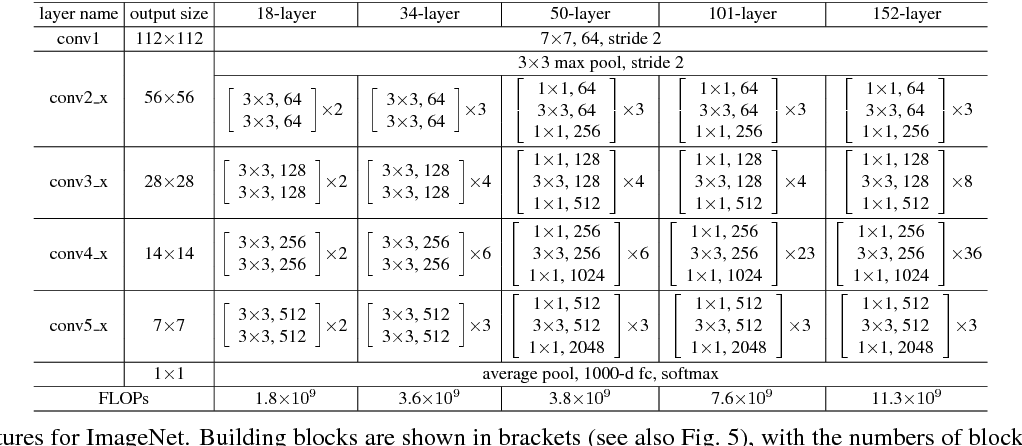

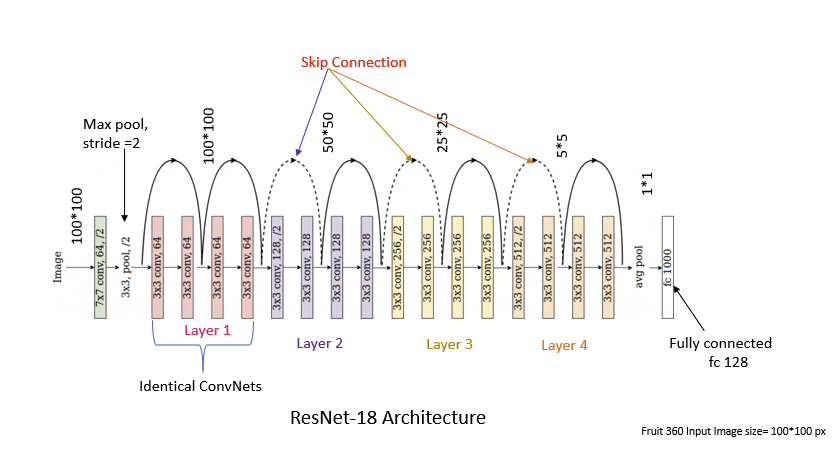

from https://www.pluralsight.com/guides/introduction-to-resnet

In [18]:
pretrained_net = torchvision.models.resnet18 (weights=torchvision.models.ResNet18_Weights.DEFAULT)
pretrained_net, #pretrained_net.layer4[1], pretrained_net.avgpool, pretrained_net.fc

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.8MB/s]


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

Next, we create the fully convolutional network instance `net`. It duplicates all the neural layers **except the last two layers** of the instance member variable `features` of `pretrained_net` and the model parameters obtained after pre-training.


In [36]:
print(list(pretrained_net.children()))
net = nn.Sequential( *list(pretrained_net.children())[:-2])
## Strips off the last two (FCN layers of the ResNet)
for param in net.parameters():
    param.requires_grad = False
print(net)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

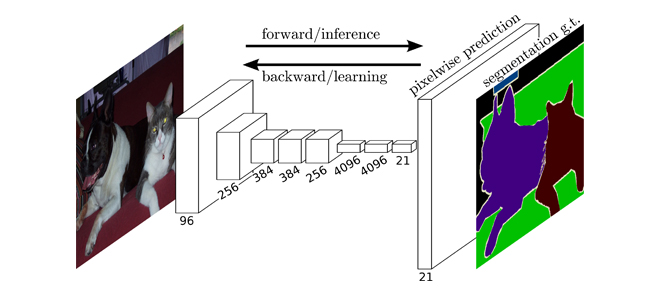

Given an input of a height and width of 256 and 256 respectively, the forward computation of `net` will reduce the height and width of the input to $1/32$ of the original, i.e., 8 and 8.


In [37]:
X = torch.rand(size=(1, 3, 256, 256))
net(X.to(devices[0])).shape

torch.Size([1, 512, 8, 8])

* Next, we transform the number of output channels to the number of categories of Pascal VOC2012 (21) through the $1\times 1$ convolution layer.

* Finally, we need
to magnify the height and width of the feature map by a factor of 32 to change them back to the height and width of the input image.

* We construct a transposed convolution layer with a stride of 32 and set the height and width of the convolution kernel to 64 and the padding to 16.

* It is not difficult to see that, if the stride is $s$, the padding is $s/2$ (assuming $s/2$ is an integer), and the height and width of the convolution kernel are $2s$, the transposed convolution kernel will magnify both the height and width of the input by a factor of $s$.


In [38]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1))
net.add_module(
    'transpose_conv',
    nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=64, padding=16,
                       stride=32)) # stride determines the upsampling factor.

Now, we will experiment with bilinear interpolation upsampling implemented by transposed convolution layers. Construct a transposed convolution layer that magnifies height and width of input by a factor of 2 and initialize its convolution kernel with the `bilinear_kernel` function.


In [39]:
conv_trans = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(in_channels=3, out_channels=3, kernel_size=4));

print('Bilinear kernel: (4 by 4):\n', conv_trans.weight.data[1,1,:,:])

Bilinear kernel: (4 by 4):
 tensor([[0.0625, 0.1875, 0.1875, 0.0625],
        [0.1875, 0.5625, 0.5625, 0.1875],
        [0.1875, 0.5625, 0.5625, 0.1875],
        [0.0625, 0.1875, 0.1875, 0.0625]])


Read the image `X` and record the result of upsampling as `Y`. In order to print the image, we need to adjust the position of the channel dimension.


In [40]:
img = torchvision.transforms.ToTensor()(d2l.Image.open(data_dir+'parking_lot_meva_1.png'))
X = img[0:3,:,:].unsqueeze(0) # adds a dimension

Y = conv_trans(X)

# What happens if we do not do the following? Try it out!
# What do you think it is doing?
out_img = Y[0].permute(1, 2, 0).detach()

print('Input image size :', X.shape, '\nOutput image size:', Y.shape)

Input image size : torch.Size([1, 3, 117, 251]) 
Output image size: torch.Size([1, 3, 234, 502])


As you can see, the transposed convolution layer magnifies both the height and width of the image by a factor of 2. It is worth mentioning that, besides to the difference in coordinate scale, the image magnified by bilinear interpolation and original image look the same.


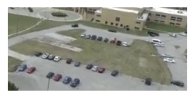

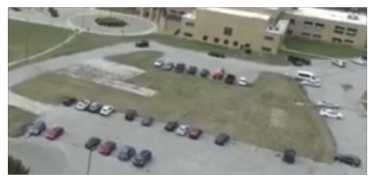

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def display_image_in_actual_size(im_data):

    dpi = mpl.rcParams['figure.dpi']
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()


display_image_in_actual_size (img.permute(1, 2, 0))
display_image_in_actual_size(out_img)

In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation. For a $1\times 1$ convolution layer, we use Xavier for randomly initialization.


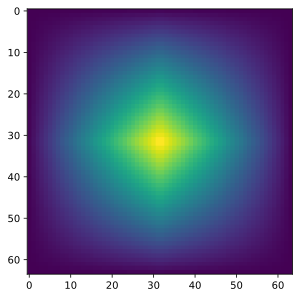

In [42]:
W = bilinear_kernel(num_classes, num_classes, 64)
#W = torch.rand(num_classes, num_classes, 64, 64)
net.transpose_conv.weight.data.copy_(W);
plt.imshow(W[1,1,:,:])

## Training

Now we can start training the model. The loss function and accuracy calculation here are not substantially different from those used in image classification. Because we use the channel of the transposed convolution layer to predict pixel categories, the `axis=1` (channel dimension) option is specified in `SoftmaxCrossEntropyLoss`. In addition, the model calculates the accuracy based on whether the prediction category of each pixel is correct.


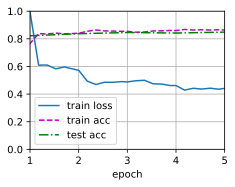

In [43]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


 Dimension of final convolution for object categories torch.Size([21, 512, 1, 1])

 Dimension of transposed convolution for object categories torch.Size([21, 21, 64, 64])
tensor(1.8223e-05)


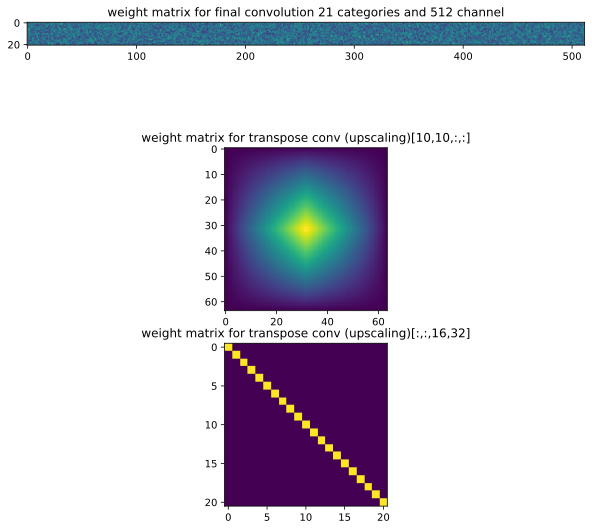

In [44]:
d2l.set_figsize((10, 10))
d2l.plt.subplot(3,1,1)
print('\n Dimension of final convolution for object categories', net.final_conv.weight.data.shape)
d2l.plt.imshow(net.final_conv.weight.data[:,:,0,0].cpu())
d2l.plt.title('weight matrix for final convolution 21 categories and 512 channel')

d2l.plt.subplot(3,1,2)
print('\n Dimension of transposed convolution for object categories', net.transpose_conv.weight.data.shape)
WT = net.transpose_conv.weight.data[10,10,:,:].cpu()
print(torch.max(WT - W [10,10,:,:]))
d2l.plt.imshow(WT)
d2l.plt.title('weight matrix for transpose conv (upscaling)[10,10,:,:]')

d2l.plt.subplot(3,1,3)
d2l.plt.imshow(net.transpose_conv.weight.data[:,:,16,32].cpu())
d2l.plt.title('weight matrix for transpose conv (upscaling)[:,:,16,32]');


## Prediction

During predicting, we need to standardize the input image in each channel and transform them into the four-dimensional input format required by the convolutional neural network.


In [45]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

To visualize the predicted categories for each pixel, we map the predicted categories back to their labeled colors in the dataset.


In [46]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

# Large images
The size and shape of the images in the test dataset vary. Because the model uses a transposed convolution layer with a stride of 32, when the height or width of the input image is not divisible by 32, the height or width of the transposed convolution layer output deviates from the size of the input image. In order to solve this problem, we can crop multiple rectangular areas in the image with heights and widths as integer multiples of 32, and then perform forward computation on the pixels in these areas. When combined, these areas must completely cover the input image. When a pixel is covered by multiple areas, the average of the transposed convolution layer output in the forward computation of the different areas can be used as an input for the softmax operation to predict the category.

For the sake of simplicity, we only read a few large test images and crop an area with a shape of $320\times480$ from the top-left corner of the image. Only this area is used for prediction. For the input image, we print the cropped area first, then print the predicted result, and finally print the labeled category.


In [47]:
import os, random
def read_voc_images(voc_dir, n, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    random.shuffle(images)
    for i in range(n):
        features.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'JPEGImages', f'{images[i]}.jpg')))
        labels.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'SegmentationClass', f'{images[i]}.png'),
                mode))
    return features, labels

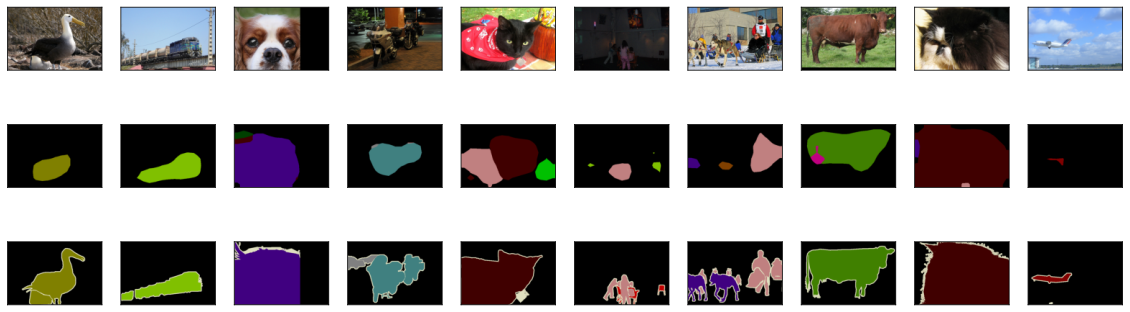

In [48]:
#voc_dir = d2l.download_extract( 'voc2012', 'VOCdevkit/VOC2012')
#voc_dir ='../data/VOCdevkit/VOC2012'
n, imgs = 10, []

test_images, test_labels = read_voc_images(voc_dir, n, False) # this are already in an earlier

for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(test_labels[i],
                                               *crop_rect).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## Summary

* The fully convolutional network first uses the convolutional neural network to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer to output the category of each pixel.
* In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation.



# Assignment (Fully Convolutional Networks)

1. If we randomly initialize the transposed convolution layer, what will happen to the result? Show examples.

1. Improve the accuracy of the above model (`net`) by tuning the hyperparameters. List the hyperparameters that can be tuned. Report on how you searched for the final choice of the hyperparameters.



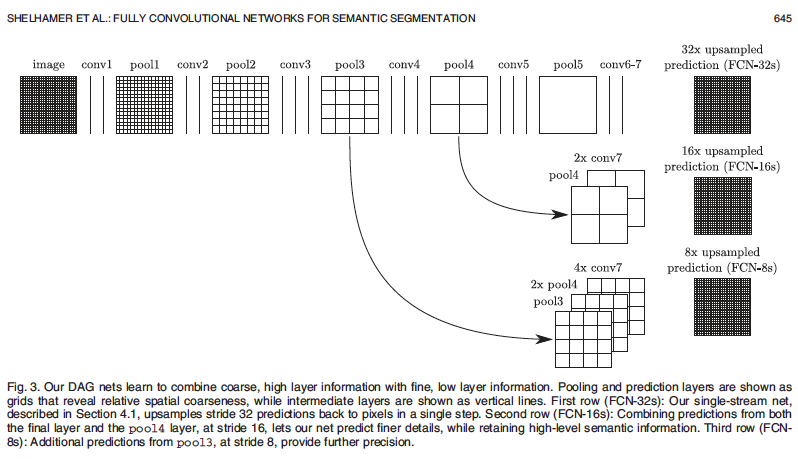

# Using torchvision for Semantic Segmentation

Now before we get started, we need to know about the inputs and outputs of these semantic segmentation models.<br/>
So, let's start!

These models expect a 3-channled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

So, the input is `[Ni x Ci x Hi x Wi]`<br/>
where,
- `Ni` -> the batch size
- `Ci` -> the number of channels (which is 3)
- `Hi` -> the height of the image
- `Wi` -> the width of the image

And the output of the model is `[No x Co x Ho x Wo]`<br/>
where,
- `No` -> is the batch size (same as `Ni`)
- `Co` -> **is the number of classes that the dataset have!**
- `Ho` -> the height of the image (which is the same as `Hi` in almost all cases)
- `Wo` -> the width of the image (which is the same as `Wi` in almost all cases)

Alright! And just one more thing!
The `torchvision` models outputs an `OrderedDict` and not a `torch.Tensor` <br/>
And in `.eval()` mode it just has one key `out` and thus to get the output we need to get the value
stored in that `key`.

The `out` key of this `OrderedDict` is the key that holds the output. <br/>
So, this `out` key's value has the shape of `[No x Co x Ho x Wo]`.

Now! we are ready to play :)

### FCN with Resnet-101 backbone

FCN - Fully Convolutional Netowrks, are among the most early invented Neural Networks for the task of Semantic Segmentation.

Let's load one up!

In [49]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:03<00:00, 65.1MB/s]


In [50]:
fcn,

(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

And that's it we have a pretrained model of `FCN` (which stands for Fully Convolutional Neural Networks) with a `Resnet101` backbone :)

Now, let's get an image!

2024-03-21 15:20:02 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


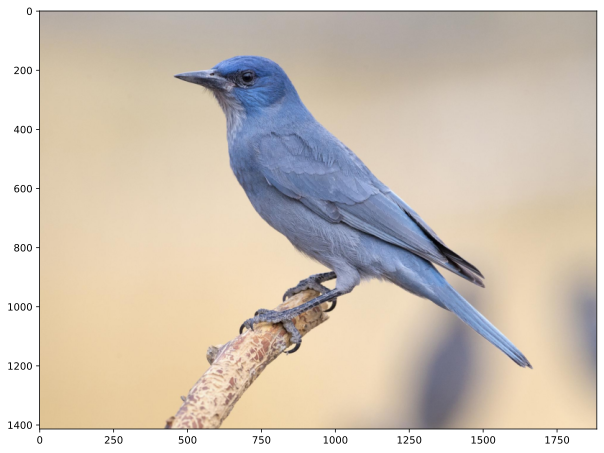

In [51]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

Now, that we have the image we need to preprocess it and normalize it! <br/>
So, for the preprocessing steps, we:
- Resize the image to `(256 x 256)`
- CenterCrop it to `(224 x 224)`
- Convert it to Tensor - all the values in the image becomes between `[0, 1]` from `[0, 255]`
- Normalize it with the Imagenet specific values `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

And lastly, we unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]` <br/>
We need a batch dimension while passing it to the models.

In [52]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 #T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Let's see what the above code cell does </br>
`T.Compose` is a function that takes in a `list` in which each element is of `transforms` type and </br>
it returns a object through which we can
pass batches of images and all the required transforms will be applied to the images.

Let's take a look at the transforms applied on the images:
- `T.Resize(256)` : Resizes the image to size `256 x 256`
- `T.CenterCrop(224)` : Center Crops the image to have a resulting size of `224 x 224`
- `T.ToTensor()` : Converts the image to type `torch.Tensor` and have values between `[0, 1]`
- `T.Normalize(mean, std)` : Normalizes the image with the given mean and standard deviation.

Alright! Now that we have the image all preprocessed and ready! Let's pass it through the model and get the `out` key.<br/>
As I said, the output of the model is a `OrderedDict` so, we need to take the `out` key from that to get the output of the model.

In [53]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 256, 341])


Alright! So, `out` is the final output of the model. And as we can see, its shape is `[1 x 21 x H x W]` as discussed earlier. So, the model was trained on `21` classes and thus our output have `21` channels!<br/>

Now, what we need to do is make this `21` channeled output into a `2D` image or a `1` channeled image, where each pixel of that image corresponds to a class!

So, the `2D` image, (of shape `[H x W]`) will have each pixel corresponding to a class label, and thus <br/>
for each `(x, y)` in this `2D` image will correspond to a number between `0 - 20` representing a class.

And how do we get there from this `[1 x 21 x H x W]`?<br/>
We take a max index for each pixel position, which represents the class<br/>

In [54]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(256, 341)
[0 3]


Alright! So, we as we can see now have a `2D` image. Where each pixel corresponds to a class!
The last thing is to take this `2D` image where each pixel corresponds to a class label and convert this<br/>
into a segmentation map where each class label is converted into a `RGB` color and thus helping in easy visualization.

We will use the following function to convert this `2D` image to an `RGB` image wheree each label is mapped to its
corresponding color.

In [55]:
# Define the helper function
def decode_segmap(image, nc=21):

  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

Let's see what we are doing inside this function!

first `label_colors` stores the colors for each of the clases, according to the index </br>
So, the color for the  first class which is `background` is stored in the `0`th index of the `label_colors` list,
the second class which is `aeroplane` is stored at index `1` of `label_colors`.

Now, we are to create an `RGB` image from the `2D` image passed. So, what we do, is we create empty `2D` matrices for all 3 channels.

So, `r`, `g`, and `b` are arrays which will form the `RGB` channels for the final image. And each are of shape `[H x W]`
(which is same as the shape of `image` passed in)

Now, we loop over each class color we stored in `label_colors`.
And we get the indexes in the image where that particular class label is present. (`idx = image == l`)
And then for each channel, we put its corresponding color to those pixels where that class label is present.

And finally we stack the 3 seperate channels to form a `RGB` image.

Okay! Now, let's use this function to see the final segmented output!

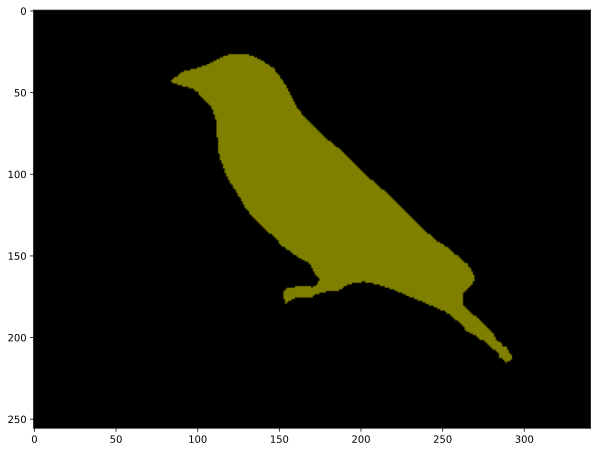

In [56]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()


That's the bird!

Also, Do note that the image after segmentation is smaller than the original image as in the preprocessing step the image is resized and cropped.

Next, let's move all this under one function and play with a few more images!

In [57]:
def segment(net, path, show_orig=True, dev='cuda'):
  print (path)
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

And let's get a new image!

/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/Wildtrack/C1/00000015.png


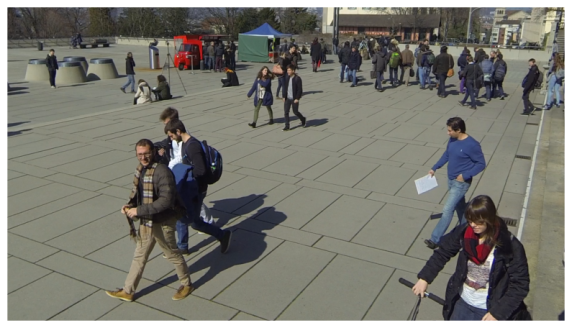

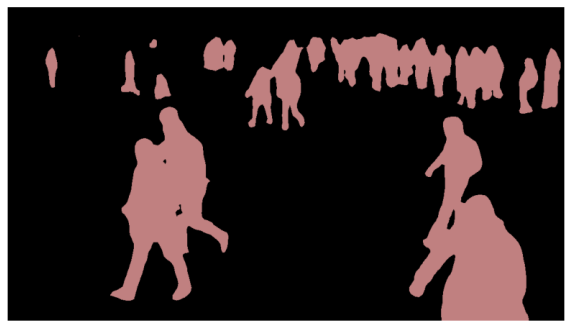

In [58]:
#!wget -nv https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg -O horse.png

segment(fcn, data_dir+'Wildtrack/C1/00000015.png')

### DeepLabv3

In [59]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:05<00:00, 47.0MB/s]


Alright! Now we have a very good-level segmentation model!
Let's see how we perform with the same image on this model!

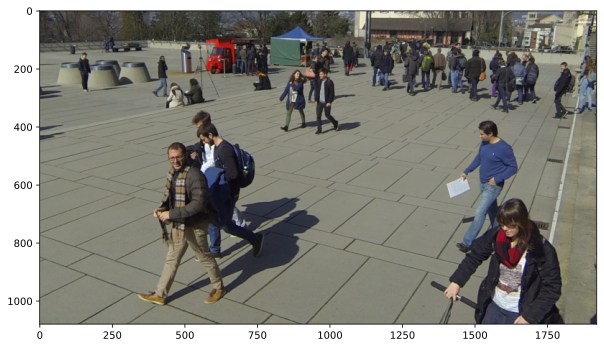

Segmentation Image on FCN
/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data//Wildtrack/C1/00000015.png


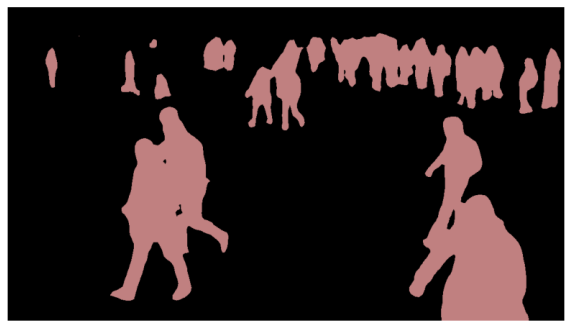

Segmentation Image on DeepLabv3
/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/Wildtrack/C1/00000015.png


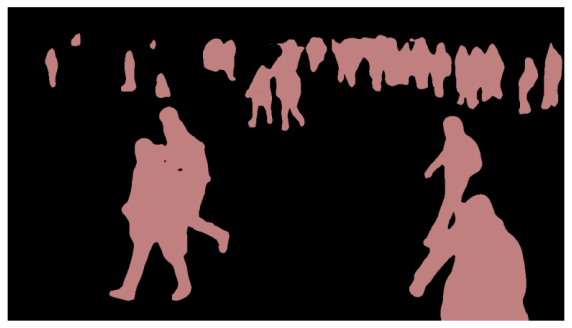

In [60]:
#!wget -nv "https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg" -O person.png
img = Image.open(data_dir+'Wildtrack/C1/00000015.png')
plt.imshow(img); plt.show()

print ('Segmentation Image on FCN')
segment(fcn, path=data_dir+'/Wildtrack/C1/00000015.png', show_orig=False)

print ('Segmentation Image on DeepLabv3')
segment(dlab, path=data_dir+'Wildtrack/C1/00000015.png', show_orig=False)